In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [108]:
sParser = SlackDataLoader(channel_path)
users = sParser.get_users()
nChannel = sParser.get_channels()
channel_path = (rpath + "/anonymized/")

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [71]:
folder_paths = []
for dir_name , subdir_list , file_list in os.walk(rpath + '/anonymized'):
    # if dir_name.endswith("all-week8") or dir_name.endswith("all-week9"):
        folder_paths.append(dir_name)
        
# week8 = sParser.slack_parser(folder_paths[1])
ans = []
for i in range(len(folder_paths)):
    ans.append(sParser.slack_parser(folder_paths[i]))

week8 = pd.concat([ans[0] , ans[1]])
print(result.head())



# Find the top and bottom 10 users by Reply count
top_10_reply_users = week8.groupby('sender_name')['reply_count'].sum().nlargest(10).reset_index()
bottom_10_reply_users = week8.groupby('sender_name')['reply_count'].sum().nsmallest(10).reset_index()

# Find the top and bottom 10 users by Mention count
top_10_mention_users = week8[week8['msg_content'].str.contains('<@')].groupby('sender_name').size().nlargest(10).reset_index()
bottom_10_mention_users = week8[week8['msg_content'].str.contains('<@')].groupby('sender_name').size().nsmallest(10).reset_index()

# Find the top and bottom 10 users by Message count
top_10_message_users = week8.groupby('sender_name').size().nlargest(10).reset_index()
bottom_10_message_users = week8.groupby('sender_name').size().nsmallest(10).reset_index()

# Find the top and bottom 10 users by Reaction count
top_10_reaction_users = week8.groupby('sender_name')['reply_users_count'].sum().nlargest(10).reset_index()
bottom_10_reaction_users = week8.groupby('sender_name')['reply_users_count'].sum().nsmallest(10).reset_index()

# Display the results
print("Top 10 Users by Reply Count:")
print(top_10_reply_users)

print("\nBottom 10 Users by Reply Count:")
print(bottom_10_reply_users)

print("\nTop 10 Users by Mention Count:")
print(top_10_mention_users)

print("\nBottom 10 Users by Mention Count:")
print(bottom_10_mention_users)

print("\nTop 10 Users by Message Count:")
print(top_10_message_users)

print("\nBottom 10 Users by Message Count:")
print(bottom_10_message_users)

print("\nTop 10 Users by Reaction Count:")
print(top_10_reaction_users)

print("\nBottom 10 Users by Reaction Count:")
print(bottom_10_reaction_users)


[    msg_type                                        msg_content  \
0    message            <@U03U1FNPEUX> torch             1.12.1   
1    message  what is the python version you used to create ...   
2    message                                                3.8   
3    message              Thank you, my python version was 3.10   
4    message  <https://realpython.com/linear-programming-pyt...   
..       ...                                                ...   
105  message  i use to install based on the guide on the off...   
106  message           i meant creating new environment for it!   
107  message            i used conda environment but no success   
108  message                   could you share the guide please   
109  message  <https://causalnex.readthedocs.io/en/latest/02...   

       sender_name      msg_sent_time msg_dist_type  time_thread_start  \
0    Travis Butler  1666513935.439479          user  1666453751.515939   
1    Travis Butler  1666516757.437419         

In [15]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

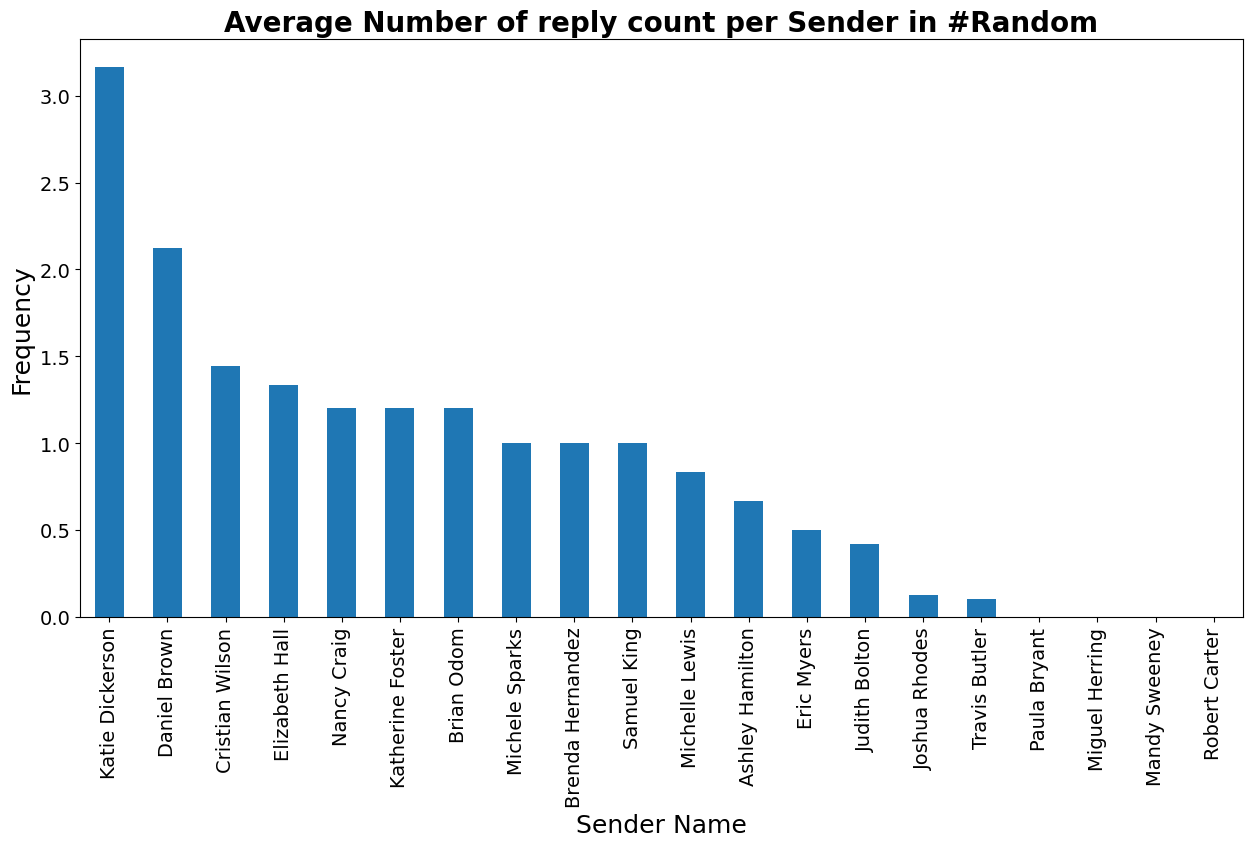

In [16]:
draw_avg_reply_count(week8)

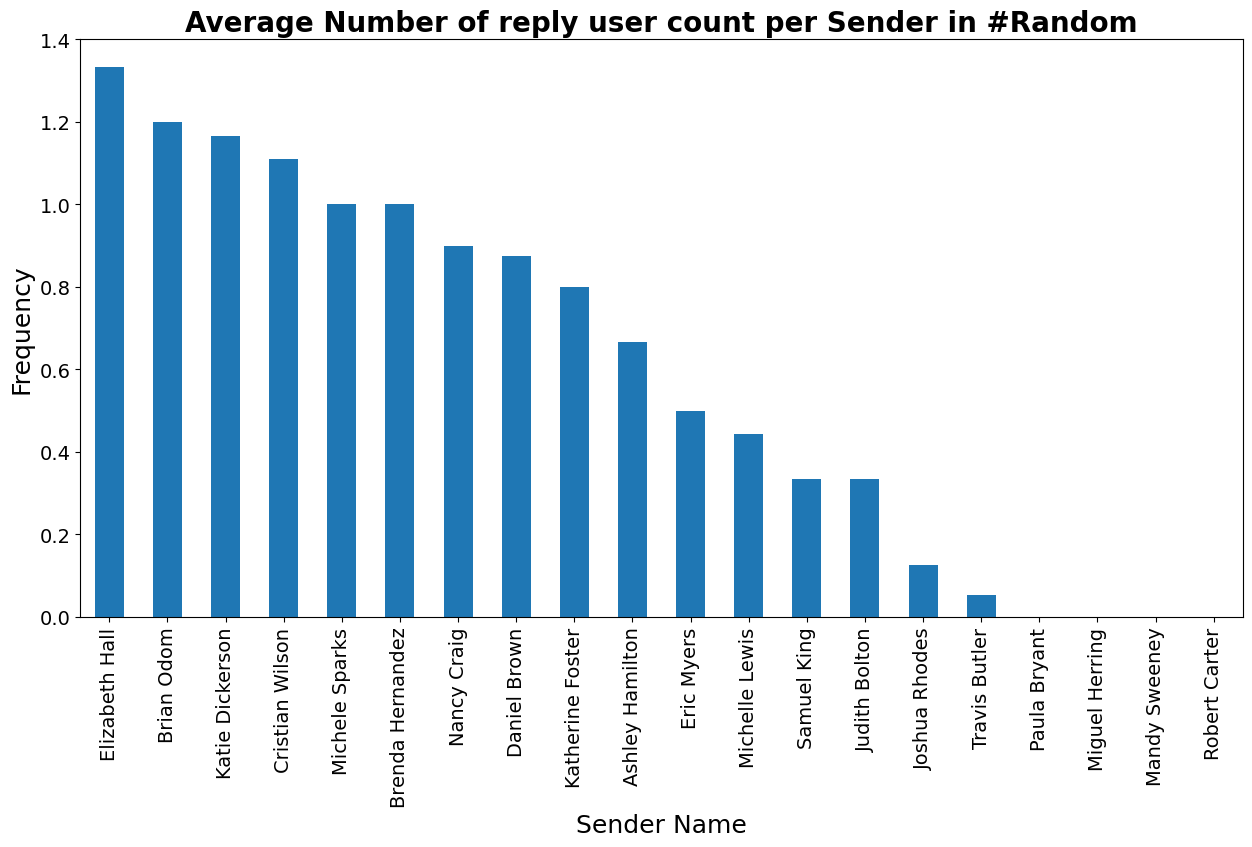

In [22]:
draw_avg_reply_users_count(week8, channel='Random')

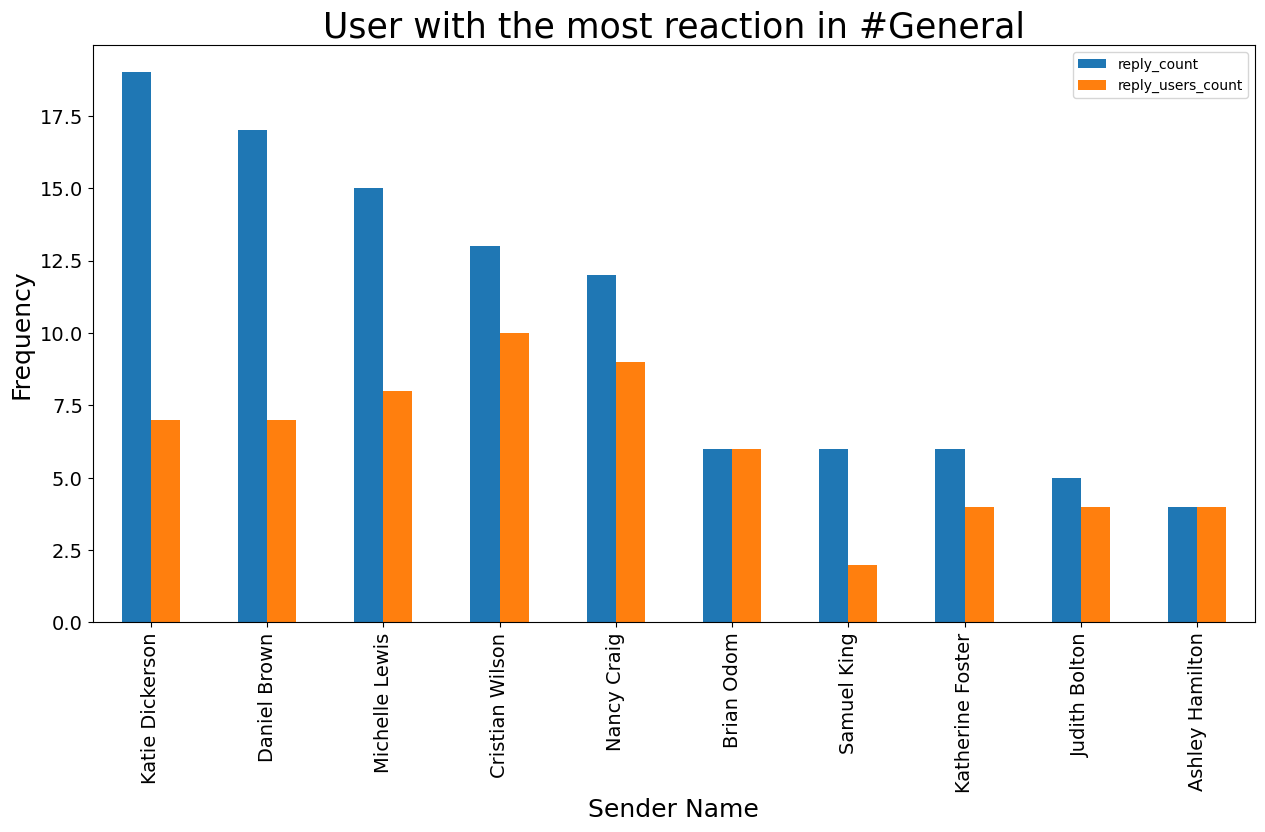

In [21]:
draw_user_reaction(week8, channel='General')

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

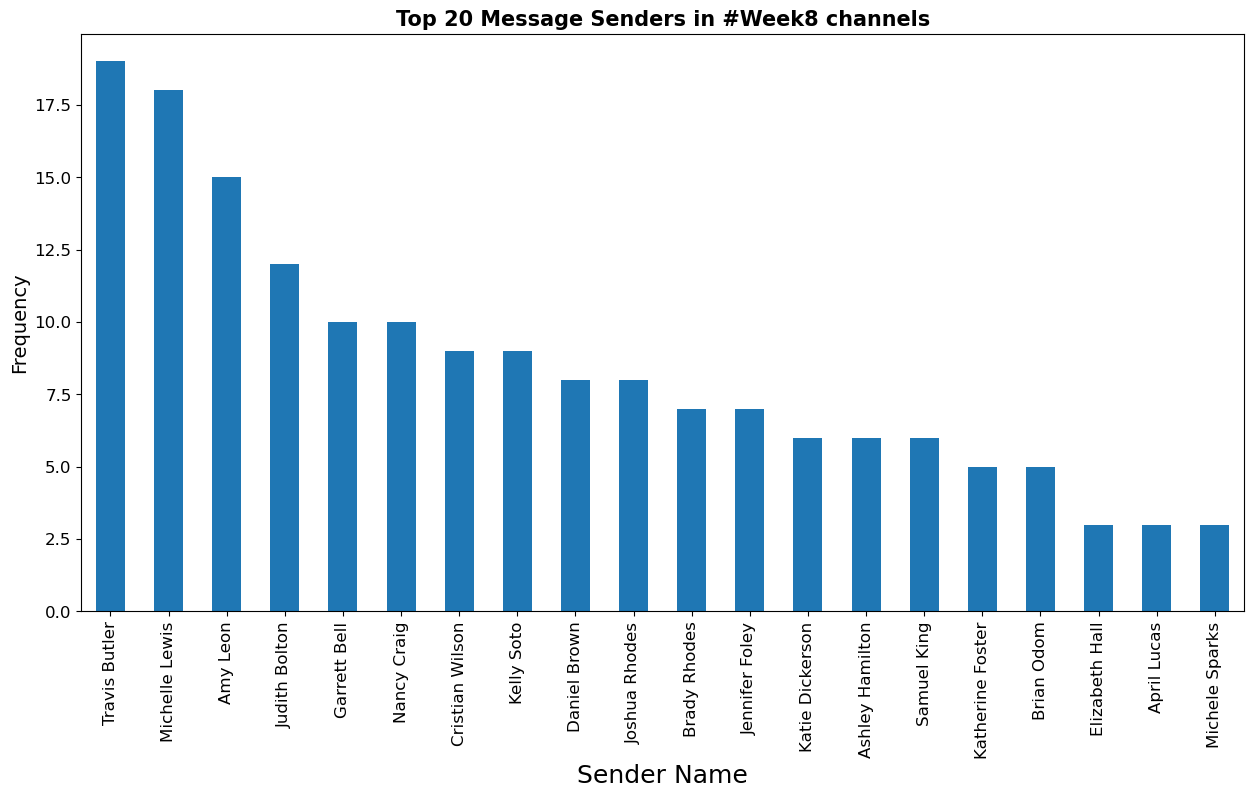

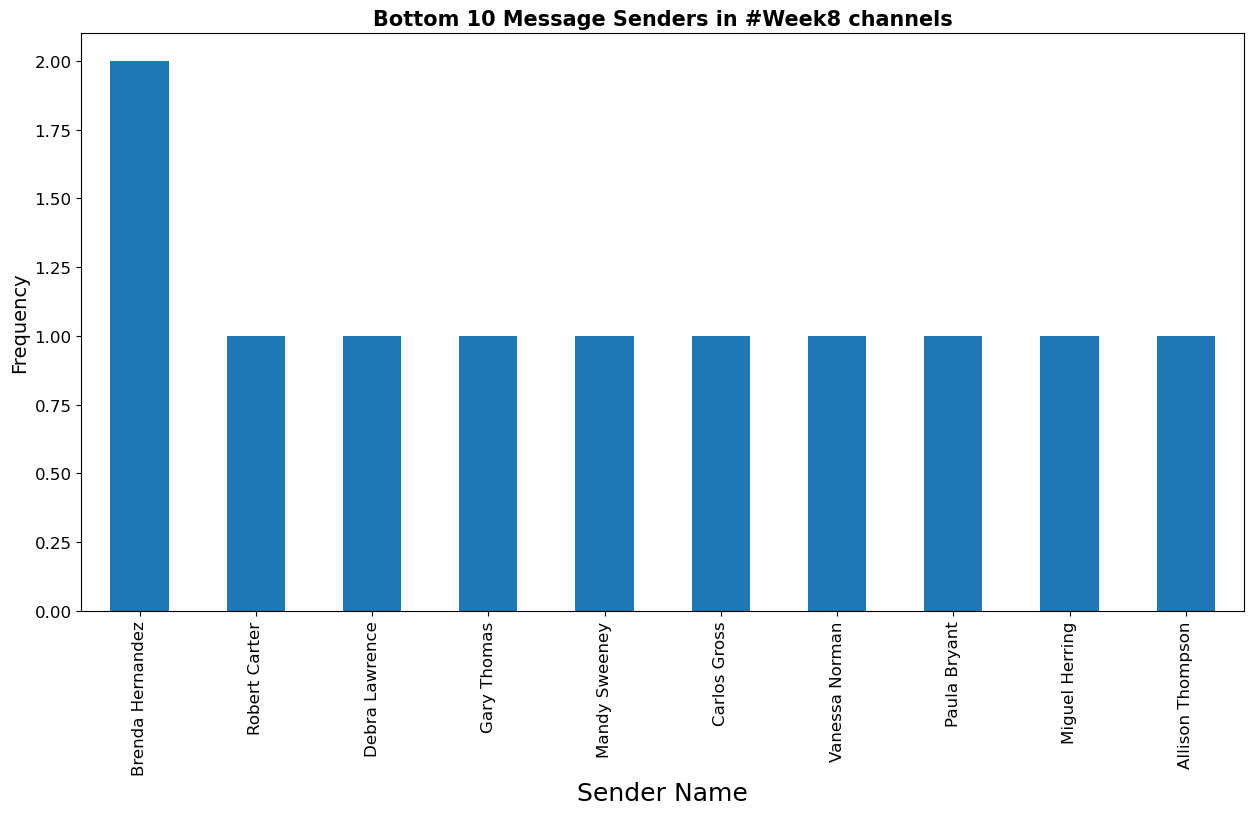

In [19]:
 get_top_20_user(week8, channel='Week8')

In [132]:
# import pandas as pd

# Assuming you have a DataFrame named df_users with columns 'user_id' and 'reply_count'
# Example DataFrame structure: df_users = pd.DataFrame({'user_id': ['user1', 'user2', ...], 'reply_count': [count1, count2, ...]})

# Combine reply counts for each user across all channels
# Example: Replace this with your actual DataFrame
df_users= pd.DataFrame()

all_users_combined = df_users.groupby('user_id')['reply_count'].sum()

# Check if all_users_combined is not empty
if not all_users_combined.empty:
    # Find the user with the highest reply count
    highest_user_id = all_users_combined.idxmax()
    highest_reply_count = all_users_combined.loc[highest_user_id]

    # Get user names from user IDs
    user_names = {user['id']: user['name'] for user in sParser.get_users()}

    # Get the real name of the user with the highest reply count
    highest_user_name = user_names.get(highest_user_id, "Unknown")

    # Print the result
    print(f"The user with the highest number of reply counts across all channels is {highest_user_name} with a count of {highest_reply_count}")
else:
    print("No users with reply counts found across all channels.")


NameError: name 'count1' is not defined

In [ ]:
# Visualize reply counts per user per channel


: 

In [ ]:
# what is the time range of the day that most messages are sent?


: 

In [ ]:
# what kind of messages are replied faster than others?

: 

In [ ]:
# Relationship between # of messages and # of reactions

: 

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

: 

In [ ]:
# Which users got the most reactions?

: 

In [ ]:
# Model topics mentioned in the channel

: 

In [ ]:
# What are the topics that got the most reactions?

: 

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?

: 